In [ ]:
"""
Centaur Drawings || 2023.

#Authors:
    Uroš Krčadinac | krcadinac.com 
    Andrej Alfirevic | xladn0.rf.gd 
    Zeljko Petrovic | instagram@just.blue.dot

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see https://www.gnu.org/licenses.
"""


# Colab installations
# !pip install git+git://github.com/cpmpercussion/keras-mdn-layer.git#egg=keras-mdn-layer
import sys
!{sys.executable} -m pip install keras-mdn-layer

!git clone https://github.com/parthenocissus/stickmen.git

!pip install svgpathtools
!pip install svgwrite
import keras
import tensorflow as tf
import mdn
import glob
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [ ]:
media_path = 'stickmen/static/media/Databases/megabase/'

def parse_json_pictograms_x4(media_path=media_path):
    svg_data = []
    float_formatter = "{:.2f}".format
    np.set_printoptions(formatter={'float_kind': float_formatter})
    # Going trough all JSON files in the media_path directory
    print("files:")
    for f in glob.iglob(media_path + "/*"):
        print(f"_______\n{f}")
        data = json.load(open(f, 'r', encoding='utf-8'))
        pointList = data['points']
        # shape_size = get_shape_size(pointList)
        shape_size = len(pointList) + 1
        points = np.zeros(shape=(shape_size, 3), dtype=float)
        points_xflip = np.zeros(shape=(shape_size, 3), dtype=float)
        points_yflip = np.zeros(shape=(shape_size, 3), dtype=float)
        points_xyflip = np.zeros(shape=(shape_size, 3), dtype=float)
        itr = 0
        current = {"x": 0, "y": 0}
        current_flip = {"x": 0, "y": 0}
        for(i, p) in enumerate(pointList):
          x = p[0]
          y = p[1]
          pen_state = p[2]
          dx = x - current["x"]
          dy = y - current["y"]
          points[itr] = [dx, dy, pen_state]
          current = {"x": x, "y": y}
          x_flip = 17 - x
          y_flip = 35 - y
          dx_flip = x_flip - current_flip["x"]
          dy_flip = y_flip - current_flip["y"]
          points_xflip[itr] = [dx_flip, dy, pen_state]
          points_yflip[itr] = [dx, dy_flip, pen_state]
          points_xyflip[itr] = [dx_flip, dy_flip, pen_state]
          current_flip = {"x": x_flip, "y": y_flip}
          itr += 1
          last_points = None
          for i in data:
              if last_points is None:
                  svg_data.append(points)
                  last_points = points
              else:
                  dx = points[0] - last_points[0]
                  dy = points[1] - last_points[1]
                  svg_data.append([dx, dy, points[2]])
                  last_point = points
#append

        svg_data.append(points)
        svg_data.append(points_xflip)
        svg_data.append(points_yflip)
        svg_data.append(points_xyflip)

    return np.array(svg_data, dtype=object)

tdata = parse_json_pictograms_x4()

In [ ]:
train_set = tdata
valid_set = tdata
test_set = tdata
print(tdata)

Shape: (41, 3)
[[3.56 9.24 0.00]
 [1.28 1.68 0.00]
 [0.56 -0.40 0.00]
 [-0.08 -1.04 0.00]
 [-0.48 -0.40 0.00]]


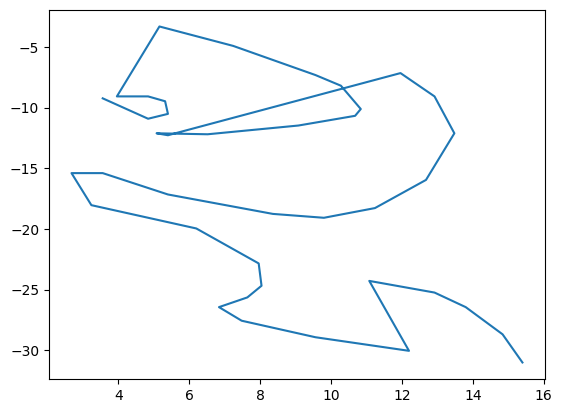

In [ ]:
example = train_set[31000]
print("Shape:", example.shape)
print(example[:5])
plt.plot(example.T[0].cumsum(), -1 * example.T[1].cumsum())
plt.show()

In [ ]:
# tier
SEQ_LEN = 60 # 124 100 30 30
BATCH_SIZE = 65 # 64 51 20 49
HIDDEN_UNITS = 512

EPOCHS = 100
SEED = 2345
random.seed(SEED)
np.random.seed(SEED)
OUTPUT_DIMENSION = 3
NUMBER_MIXTURES = 10

# layers
model = keras.Sequential()
model.add(keras.layers.LSTM(HIDDEN_UNITS, batch_input_shape=(None, SEQ_LEN, OUTPUT_DIMENSION), return_sequences=True))
model.add(keras.layers.LSTM(HIDDEN_UNITS))
model.add(mdn.MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES))
model.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer=tf.keras.optimizers.Adam())
model.summary()

In [ ]:
# Functions for slicing up data
def slice_sequence_examples(sequence, num_steps):
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
    return xs

def seq_to_singleton_format(examples):
    xs = []
    ys = []
    for ex in examples:
        xs.append(ex[:-1])
        ys.append(ex[-1])
    return (xs,ys)

# Prepare training data as X and Y.
slices = []
for seq in tdata:
    slices += slice_sequence_examples(seq, SEQ_LEN + 1)
X, y = seq_to_singleton_format(slices)

X = np.array(X)
y = np.array(y)

print("Number of training examples:")
print("X:", X.shape)
print("y:", y.shape)

Number of training examples:
X: (9576, 40, 3)
y: (9576, 3)


In [ ]:
# Train!
EPOCHS = 100
history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[keras.callbacks.TerminateOnNaN()])

In [ ]:
model.save('31k_Model_100epoch60seq65batch512hidden.h5')

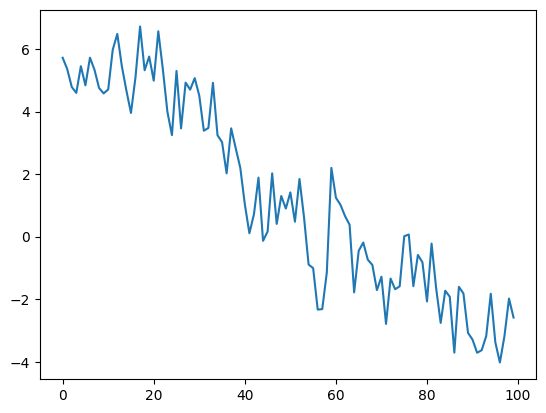

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.show()

In [ ]:
decoder = keras.Sequential()
decoder.add(keras.layers.LSTM(HIDDEN_UNITS, batch_input_shape=(1,1,OUTPUT_DIMENSION), return_sequences=True, stateful=True))
decoder.add(keras.layers.LSTM(HIDDEN_UNITS, stateful=True))
decoder.add(mdn.MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES))
decoder.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer=tf.keras.optimizers.Adam())
decoder.summary()
decoder.set_weights(model.get_weights()) #set newgen model

In [ ]:
# Generating new drawings...
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def zero_start_position():
    # A zeroed out start position with pen down
    out = np.zeros((1, 1, 3), dtype=np.float32)
    out[0, 0, 2] = 1 # set pen down. originaly 1
    return out

def generate_sketch(model, start_pos, num_points=100):
     return None

def cutoff_stroke(x):
    return np.greater(x,0.5) * 1.0 #0.5

def plot_sketch(sketch_array):

    # Plot a sketch quickly to see what it looks like.
    sketch_df = pd.DataFrame({'x':sketch_array.T[0],'y':sketch_array.T[1],'z':sketch_array.T[2]})
    sketch_df.x = sketch_df.x.cumsum()
    sketch_df.y = -1 * sketch_df.y.cumsum()

    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(111)

    ax1.plot(sketch_df.x,sketch_df.y,'r-')
    plt.show()

In [ ]:
# Generating SVGs
# Via Hardmaru's Drawing Functions from write-rnn-tensorflow
# https://github.com/hardmaru/write-rnn-tensorflow/blob/master/utils.py

import svgwrite
from IPython.display import SVG, display

def get_bounds(data, factor):
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)

    return (min_x, max_x, min_y, max_y)

def draw_strokes(data, factor=1, svg_filename='sample.svg'):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1

    abs_x = 25 - min_x
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)

    command = "m"

    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        lift_pen = data[i, 2]
        p += command + str(x) + "," + str(y) + " "

    the_color = "black"
    stroke_width = 1

    dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))

    dwg.save()
    dwg.saveas(svg_filename)
    display(SVG(dwg.tostring()))


c = 0

In [ ]:
temperature = 0.001
# temperature = 1
# temperature = 2
# temperature = 10 # bigger the temp, bigger the randomness
# sigma_temp = 0.01
sigma_temp = -1

p = zero_start_position()
sketch = [p.reshape(3,)]
#55
for i in range(32):
    params = decoder.predict(p.reshape(1,1,3))
    p = mdn.sample_from_output(params[0], OUTPUT_DIMENSION, NUMBER_MIXTURES, temp=temperature, sigma_temp=sigma_temp)
    sketch.append(p.reshape((3,)))

sketch = np.array(sketch)
decoder.reset_states()
filename= 'output_plot0' + str(c) + '.svg'
sketch.T[2] = cutoff_stroke(sketch.T[2])
draw_strokes(sketch, factor=0.7)
draw_strokes(sketch, factor=0.2, svg_filename=filename)
print(filename)
c = c+1
#plot_sketch(sketch)